# Pneumonia Diagnosis

## 1. Business Problem

### 1.1 Problem Statement

Classify whether patient suffering with pneumonia based on Chest-X-Ray Images.

### 1.2 Source/Useful links

1) https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/kernels  
2) https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion  
3) https://en.wikipedia.org/wiki/Pneumonia

### 1.3 Real-world/ Business objectives and constraints

* No low-latency requirement
* Errors can be very costly

## 2. Machine Learning Problem Formulation

### 2.1 Data

#### 2.1.1 Data Overview

* Source: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
* The dataset is divided into test, train and validation data folders.
* Again the above data folders are further divided into 'NORMAL' and 'PNEUMONIA' folders

### 2.2 Mapping the real-world problem to an ML Problem

#### 2.2.1 Type of machine learning problem

There are two differennt classes and the problem is classified into Binary classification problem

#### 2.2.2 Performance metric

* Recall and precision
* confusion matrix

## 3 Exploratory Data Analysis

In [4]:
from pathlib import Path   #best library to deal with path operations
import pandas as pd
import numpy as np
from keras import backend as K
import os
import imgaug as aug      #library to augment images
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
from skimage.io import imread
import cv2
from keras.utils import to_categorical
import imgaug.augmenters as iaa
import tensorflow as tf
%matplotlib inline

In [5]:
#https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution
#Reproducibility is very important when dealing with neural networks
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(111)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [6]:
#Load the data
train_dir=Path('chest_xray/train')
val_dir=Path('chest_xray/val')
test_dir=Path('chest_xray/test')

#get paths for normal and pneumonia cases
normal_cases_dir=train_dir/'NORMAL'
pneumonia_cases_dir=train_dir/'PNEUMONIA'

#get paths of all normal and pneumonia images 
normal_cases=normal_cases_dir.glob('*.jpeg')        #considers files ending with the specified extensions
pneumonia_cases=pneumonia_cases_dir.glob('*.jpeg')

#list stores (imagepath,label)
train_data=[]

#classes for pneumonia:1 and normal:0
for img in normal_cases:
    train_data.append((img,0))
    
for img in pneumonia_cases:
    train_data.append((img,1))
    
#convert list to pandas dataframe
train_data=pd.DataFrame(train_data,columns=['image','label'],index=None)

#shuffling the data
train_data=train_data.sample(frac=1.).reset_index(drop=True)

#see few rows of the data frame
train_data.head()

,image,label
0,chest_xray\train\NORMAL\NORMAL2-IM-0454-0001.jpeg,0
1,chest_xray\train\NORMAL\NORMAL2-IM-1252-0001.jpeg,0
2,chest_xray\train\PNEUMONIA\person1050_bacteria...,1
3,chest_xray\train\PNEUMONIA\person22_bacteria_7...,1
4,chest_xray\train\PNEUMONIA\person1352_bacteria...,1


#### How many samples for each class are there in the dataset?

1    3875
0    1341
Name: label, dtype: int64


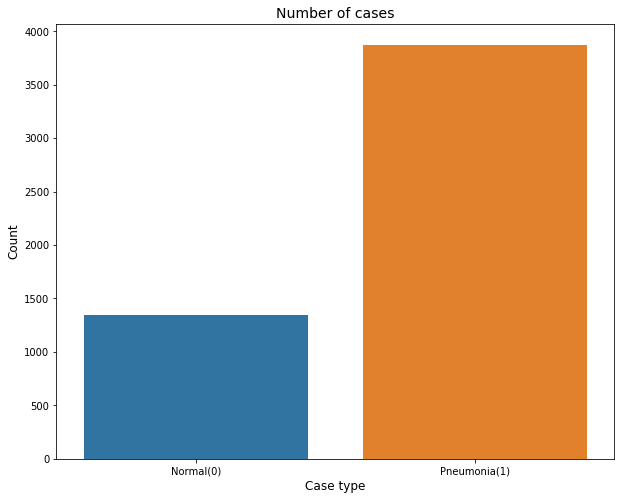

In [7]:
#get the counts for each case
cases_count=train_data['label'].value_counts()
print(cases_count)

#plot the results
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index,y=cases_count.values)
plt.title('Number of cases',fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

* __The dataset is very highly imblanced__

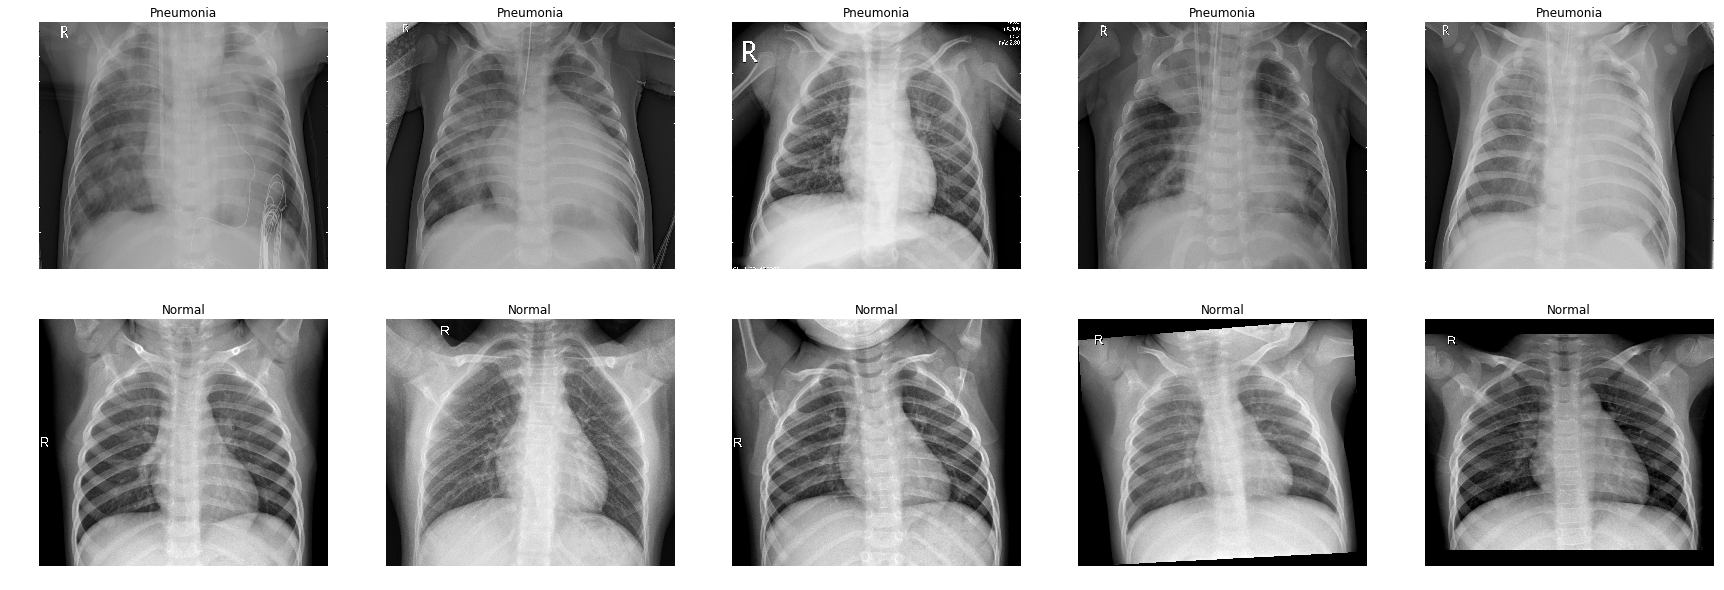

In [8]:
#get few samples for both the classes
pneumonia_samples=(train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples=(train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
samples=pneumonia_samples+normal_samples

#plot the data
f,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(10):
    img=imread(samples[i])
    ax[i//5,i%5].imshow(img,cmap='gray')
    if i<5:
        ax[i//5,i%5].set_title("Pneumonia")
    else:
        ax[i//5,i%5].set_title('Normal')
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].set_aspect('auto')
plt.show()
    


* __we cannot able to distinguish between above two classes with our naked eye__

## Pre Processing

#### Preparing validation data

In [10]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []
# Some images are in grayscale while majority of them contains 3 channels. 
#So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


#### Augmentation

In [11]:
seq=iaa.OneOf([
    iaa.Fliplr(),  # horizontal flips
    iaa.Affine(rotate=20),  # roatation
    iaa.Multiply((1.2,1.5))])  #random brightness